In [1]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from IPython.display import Image
import tensorflow as tf
import keras
from omnifold.net import weighted_binary_crossentropy
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
# Register OmniFold custom loss so Keras 3 can clone models
keras.saving.register_keras_serializable(package="omnifold")(weighted_binary_crossentropy)
import os

gpu_number="7"
os.environ['CUDA_VISIBLE_DEVICES']=gpu_number # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']=gpu_number
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)


2025-12-07 15:09:51.441466: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 15:09:52.063468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765116592.261863 1011673 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765116592.309924 1011673 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765116592.834363 1011673 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from omnifold import DataLoader, MultiFold, PET, SetStyle, HistRoutine, MLP

# OmniFold example using high-level features as inputs

In [3]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar_singletop_DR.pkl')

In [9]:
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
import PET
from my_utils import *
pythia_train, pythia_test = subset(pythia_df, 1_000_000, train_test=True)
herwig_subset = subset(herwig_df, 1_000_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train[pythia_train["pass_matched"]==1])
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test[pythia_test["pass_matched"]==1])
herwig_reco, herwig_truth = MC_data_shaper(herwig_subset[herwig_subset["pass_matched"]==1])

In [11]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth)
Y_truth_scaled = jet_scaler.transform(pythia_truth_test)
Y_reco_scaled = jet_scaler.transform(pythia_reco_test)

herwig_loader = DataLoader(reco = X_herwig_reco_scaled[:,0,0], gen = X_herwig_truth_scaled[:,0,0], weight = herwig_subset[herwig_subset["pass_matched"]==1]['eventWeight'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled[:,0,0], gen = X_pythia_truth_scaled[:,0,0], weight = pythia_train[pythia_train["pass_matched"]==1]['eventWeight'], normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test[:,0,0], gen = pythia_truth_test[:,0,0], weight = pythia_test[pythia_test["pass_matched"]==1]['eventWeight'], normalize=False)

INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


## Let's take a quick look at the data

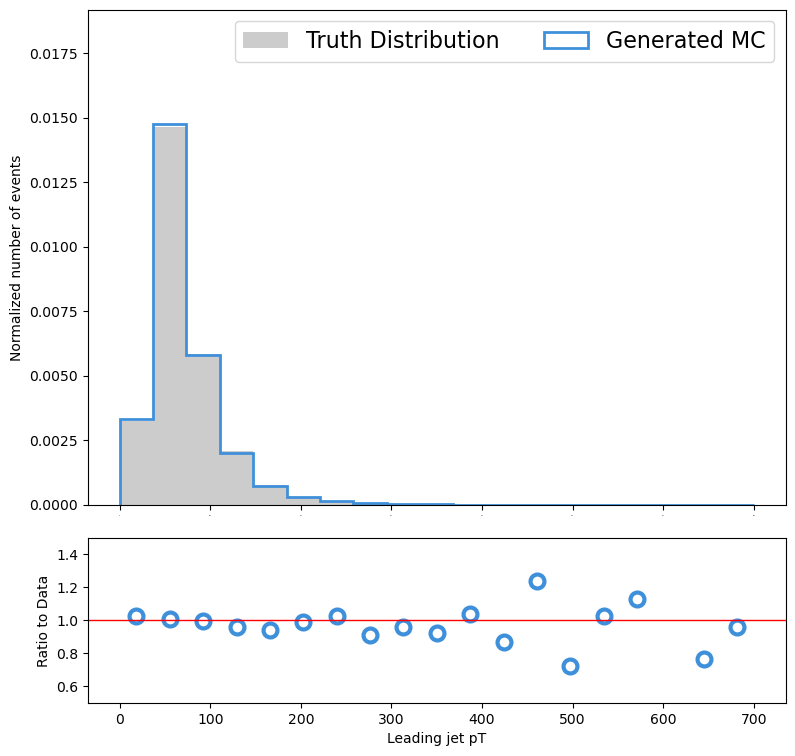

In [15]:
data_dict = {
    'Truth Distribution': herwig_truth[:,0,0],
    #'Reconstructed Data': herwig_reco[:,0,0],
    'Generated MC': pythia_truth_test[:,0,0],
    #'Reconstructed MC': pythia_reco_test[:,0,0],
}

weight_dict = {
    'Truth Distribution': herwig_loader.weight,
    #'Reconstructed Data': herwig_loader.weight,
    'Generated MC': testset_loader.weight,
    #'Reconstructed MC': testset_loader.weight,
    }

fig,_ = HistRoutine(data_dict,'Leading jet pT',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = np.linspace(0,700,20)
                    )

## Let's now create the neural network models we are going to use to model the weight distributions

In [16]:
model1 = MLP(1)
model2 = MLP(1)

I0000 00:00:1765117246.017124 1011673 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 133240 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:e3:00.0, compute capability: 9.0


In [17]:
print(model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

None


## Let's now unfold!

In [18]:
omnifold = MultiFold(
    "pT_test",
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 512,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights',
    verbose = True,
    lr = 5e-5,
)

1096 training steps at reco and 1174 steps at gen


In [19]:
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 561152, Test events used: 112230
################################################################################
Epoch 1/100


I0000 00:00:1765117257.589634 1014959 service.cc:152] XLA service 0x7edf0c004b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765117257.589677 1014959 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-12-07 15:20:57.646945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765117257.891479 1014959 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/876 ━━━━━━━━━━━━━━━━━━━━ 42:46 3s/step - loss: 7.3449

I0000 00:00:1765117258.625659 1014959 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.5355 - val_loss: 7.5409 - learning_rate: 5.0000e-05
Epoch 2/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.5412 - val_loss: 7.5408 - learning_rate: 5.0000e-05
Epoch 3/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.5510 - val_loss: 7.5408 - learning_rate: 5.0000e-05
Epoch 4/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.5367 - val_loss: 7.5408 - learning_rate: 5.0000e-05
Epoch 5/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.5352 - val_loss: 7.5408 - learning_rate: 5.0000e-05
Epoch 6/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.5400 - val_loss: 7.5409 - learning_rate: 5.0000e-05
Epoch 7/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.5507 - val_loss: 7.5410 - learning_rate: 5.0000e-05
Epoch 8/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.5454 - val_loss: 7.5409 - learning_rate: 5.0000e-05
Epoch 9/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.5397 - val_loss: 7.5409 - lea

## Now, let's evaluate the model!

In [28]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled[:,0,0],omnifold.model2,batch_size=1000)   

  1/301 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step

301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


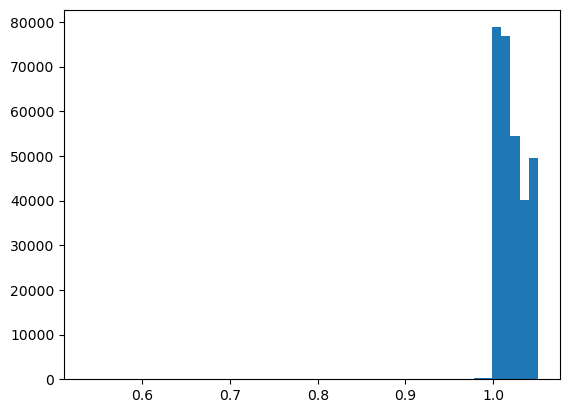

In [29]:
plt.hist(unfolded_weights, bins=50)
#plt.yscale('log')
plt.show()

## More plots!

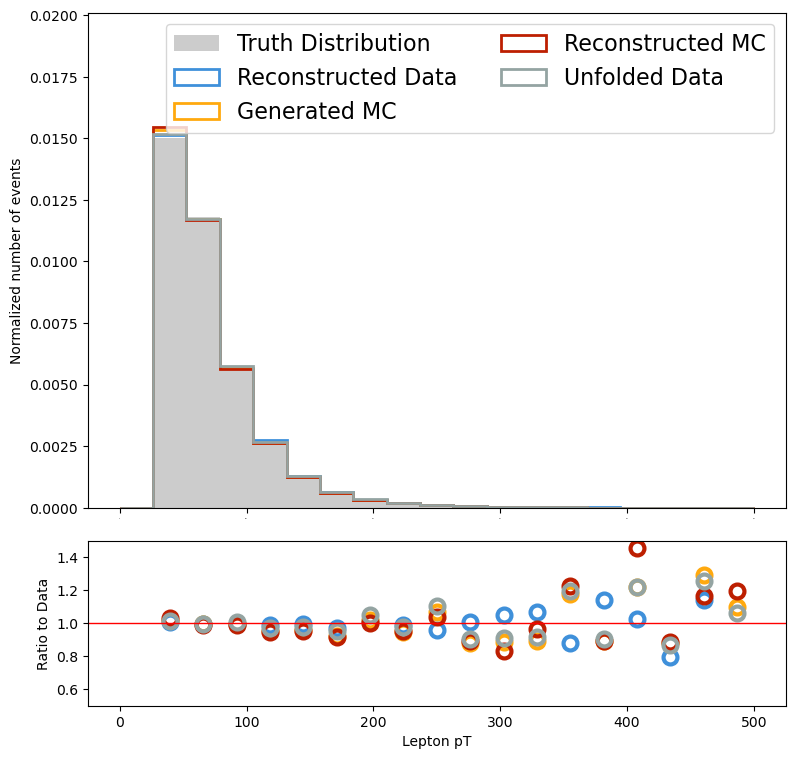

In [30]:
data_dict = {
    'Truth Distribution': herwig_truth[:,0,0],
    'Reconstructed Data': herwig_reco[:,0,0],
    'Generated MC': pythia_truth_test[:,0,0],
    'Reconstructed MC': pythia_reco_test[:,0,0],
    'Unfolded Data': pythia_truth_test[:,0,0],
}

weight_dict = {
    'Truth Distribution': herwig_loader.weight,
    'Reconstructed Data': herwig_loader.weight,
    'Generated MC': testset_loader.weight,
    'Reconstructed MC': testset_loader.weight,
    'Unfolded Data': unfolded_weights*testset_loader.weight,
    }

fig,_ = HistRoutine(data_dict,'Lepton pT',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = np.linspace(0,500,20)
                    )


In [46]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# ------------------------------------------------------------
# PARTICLE LIST & PT BINS
# ------------------------------------------------------------
particles = ['l1','b1','b2','b3','b4','j1','j2','j3','j4','j5','j6','met']

pt_binning = {
    'l1': np.linspace(0, 500, 21),
    'b1': np.linspace(0, 400, 31),
    'b2': np.linspace(0, 300, 21),
    'b3': np.linspace(0, 200, 16),
    'b4': np.linspace(0, 150, 12),
    'j1': np.linspace(0, 500, 26),
    'j2': np.linspace(0, 400, 25),
    'j3': np.linspace(0, 300, 16),
    'j4': np.linspace(0, 250, 16),
    'j5': np.linspace(0, 200, 16),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}


# ------------------------------------------------------------
# EXPIT (SIGMOID)
# ------------------------------------------------------------
def expit(x):
    return 1. / (1. + np.exp(-x))


# ------------------------------------------------------------
# UNFOLDED WEIGHT LOADER
# ------------------------------------------------------------
def load_unfolded_weights(iteration, stepn):
    model_name = f"weights/OmniFold_pT_test_iter{iteration}_step{stepn}.weights.h5"

    if not os.path.exists(model_name):
        return None

    if stepn == 1:
        model = omnifold.model1
        in_data = Y_reco_scaled[:,0,0]   # must be full vector!
        iterative_weights = np.zeros(len(in_data))
    else:
        model = omnifold.model2
        in_data = Y_truth_scaled[:,0,0]
        iterative_weights = np.zeros(len(in_data))

    model.build(input_shape=in_data.shape)
    model.load_weights(model_name)

    f = expit(model.predict(in_data, batch_size=1000))
    w = f / (1 - f)
    w = np.nan_to_num(w[:, 0], posinf=1)

    return w


# ------------------------------------------------------------
# PLOTTING UTILITY
# ------------------------------------------------------------
def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins):

    x_centers = 0.5 * (bins[1:] + bins[:-1])

    ref_name = next(iter(data_dict.keys()))
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])

    maxy = 0
    colors = ['black', '#3f90da', '#ffa90e']

    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], label=label)
        maxy = max(maxy, counts.max())

        if i > 0:
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts != 0)
            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], label=label)

    ax_main.set_ylim(0, 1.3 * maxy)
    ax_main.grid(True, ls='--', alpha=0.5)
    ax_main.legend()

    ax_ratio.axhline(1.0, color='r', ls='--')
    ax_ratio.set_ylim(0.9, 1.1)
    ax_ratio.grid(True, ls='--', alpha=0.5)
    ax_ratio.set_xlabel("$p_T$ [GeV]")


# ------------------------------------------------------------
# MAIN PLOTTING FUNCTION
# ------------------------------------------------------------
particle_index = 0

def plot_all_iterations_one_particle(n_iterations):

    pname = particles[particle_index]

    fig = plt.figure(figsize=(13, 3.2*n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    for it in range(n_iterations):
        for stepn in [1, 2]:

            unfolded = load_unfolded_weights(it, stepn)

            # pick correct axes
            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn - 1],
                height_ratios=[3, 1],
                hspace=0.05
            )

            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            # select data
            if stepn == 1:
                data_dict = {
                    "Pseudo-Data Reco": herwig_reco[:, particle_index, 0],
                    "MC Reco": pythia_reco_test[:, particle_index, 0],
                    "Reweighted": pythia_reco_test[:, particle_index, 0]
                }
                weights_dict = {
                    "Pseudo-Data Reco": herwig_loader.weight,
                    "MC Reco": testset_loader.weight,
                    "Reweighted": unfolded * testset_loader.weight
                }
            else:
                data_dict = {
                    "Truth": herwig_truth[:, particle_index, 0],
                    "Generated": pythia_truth_test[:, particle_index, 0],
                    "Unfolded": pythia_truth_test[:, particle_index, 0]
                }
                weights_dict = {
                    "Truth": herwig_loader.weight,
                    "Generated": testset_loader.weight,
                    "Unfolded": unfolded * testset_loader.weight
                }

            plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, pt_binning[pname])
            ax_main.set_title(f"Iteration {it+1}, Step {stepn}")

    plt.show()


160/301 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step

/opt/conda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


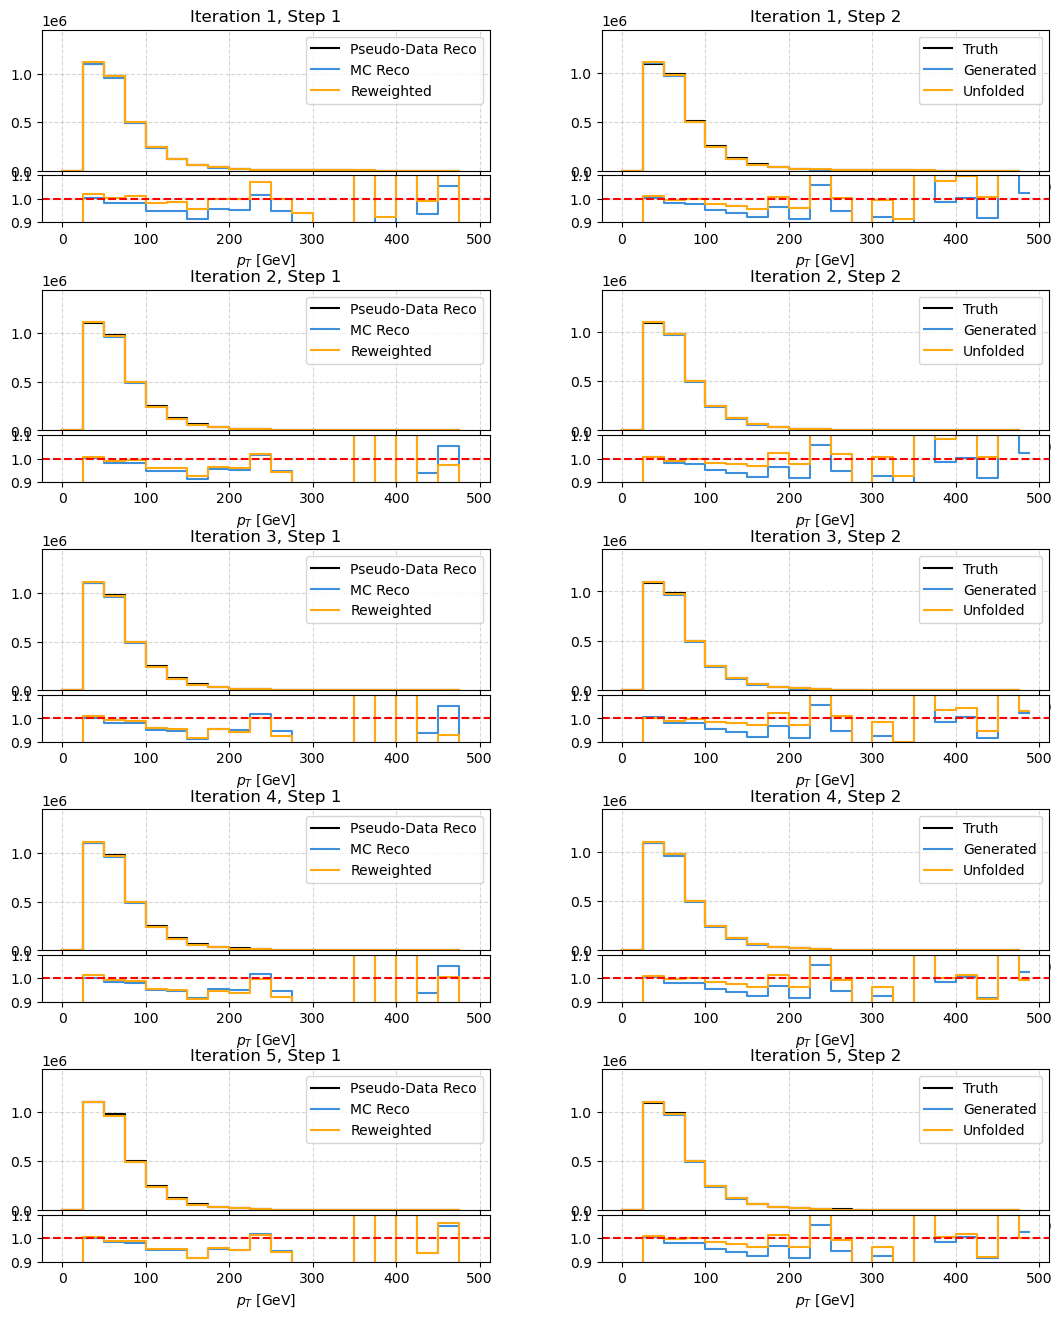

In [47]:
plot_all_iterations_one_particle(n_iterations=5)

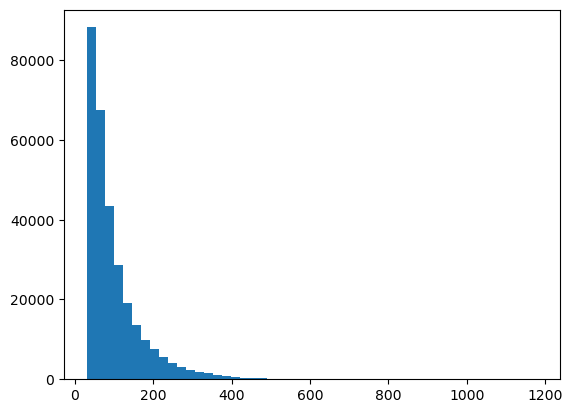

In [45]:
plt.hist(testset_loader.reco, bins=50)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
from tensorflow.keras.models import clone_model

def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins):

    x_centers = 0.5 * (bins[1:] + bins[:-1])
    ref_name = next(iter(data_dict.keys()))
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])
    maxy = 0
    colors = ['black', '#3f90da', '#ffa90e']

    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], label=label)
        maxy = max(maxy, counts.max())
        if i > 0:
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts != 0)
            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], label=label)

    ax_main.set_ylim(0, 1.3 * maxy)
    ax_main.grid(True, ls='--', alpha=0.5)
    ax_main.legend(fontsize=9)
    ax_ratio.axhline(1.0, color='r', ls='--')
    ax_ratio.set_ylim(0.9, 1.1)
    ax_ratio.grid(True, ls='--', alpha=0.5)
    ax_ratio.set_xlabel("$p_T$ [GeV]")

def load_updated_weights(it, stepn, n_ensemble=1):
    """
    Load the weights for a given iteration and step
    """
    model = omnifold.model1 if stepn==1 else omnifold.model2
    in_data = Y_reco_scaled[:,0,0] if stepn==1 else Y_truth_scaled[:,0,0]
    
    model_name = f"weights/OmniFold_pT_test_iter{it}_step{stepn}.weights.h5"
    model.build(input_shape=in_data.shape)
    model.load_weights(model_name)
    
    f = expit(model.predict(in_data, batch_size=1000))
    w = f / (1 - f)
    w = np.nan_to_num(w[:,0], posinf=1)
    return w

# ------------------------------------------------------------
# MAIN PLOTTING FUNCTION
# ------------------------------------------------------------
particle_index = 0

def plot_all_iterations_updated(n_iterations, n_ensemble=1):

    pname = particles[particle_index]
    fig = plt.figure(figsize=(13, 3.2*n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # --- Loop over iterations ---
    for it in range(n_iterations):

        # --- Replay weights up to iteration it ---
        weights_pull = np.ones_like(testset_loader.weight)
        weights_push = np.ones_like(testset_loader.weight)

        for it_replay in range(it+1):
            # Step 1
            w1 = load_updated_weights(it_replay, 1, n_ensemble)
            weights_pull = weights_push * w1
            # Step 2
            w2 = load_updated_weights(it_replay, 2, n_ensemble)
            weights_push = w2

        for stepn in [1, 2]:

            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn-1],
                height_ratios=[3,1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn==1:
                data_dict = {
                    "Pseudo-Data Reco": herwig_reco[:, particle_index, 0],
                    "MC Reco": pythia_reco_test[:, particle_index, 0],
                    "Reweighted": pythia_reco_test[:, particle_index, 0]
                }
                weights_dict = {
                    "Pseudo-Data Reco": herwig_loader.weight,
                    "MC Reco": testset_loader.weight,
                    "Reweighted": testset_loader.weight * weights_pull
                }
            else:
                data_dict = {
                    "Truth": herwig_truth[:, particle_index, 0],
                    "Generated": pythia_truth_test[:, particle_index, 0],
                    "Unfolded": pythia_truth_test[:, particle_index, 0]
                }
                weights_dict = {
                    "Truth": herwig_loader.weight,
                    "Generated": testset_loader.weight,
                    "Unfolded": testset_loader.weight * weights_push
                }

            plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, pt_binning[pname])
            ax_main.set_title(f"Iteration {it+1}, Step {stepn}")

    plt.show()


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step

152/301 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step

/opt/conda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
301/301 ━━━

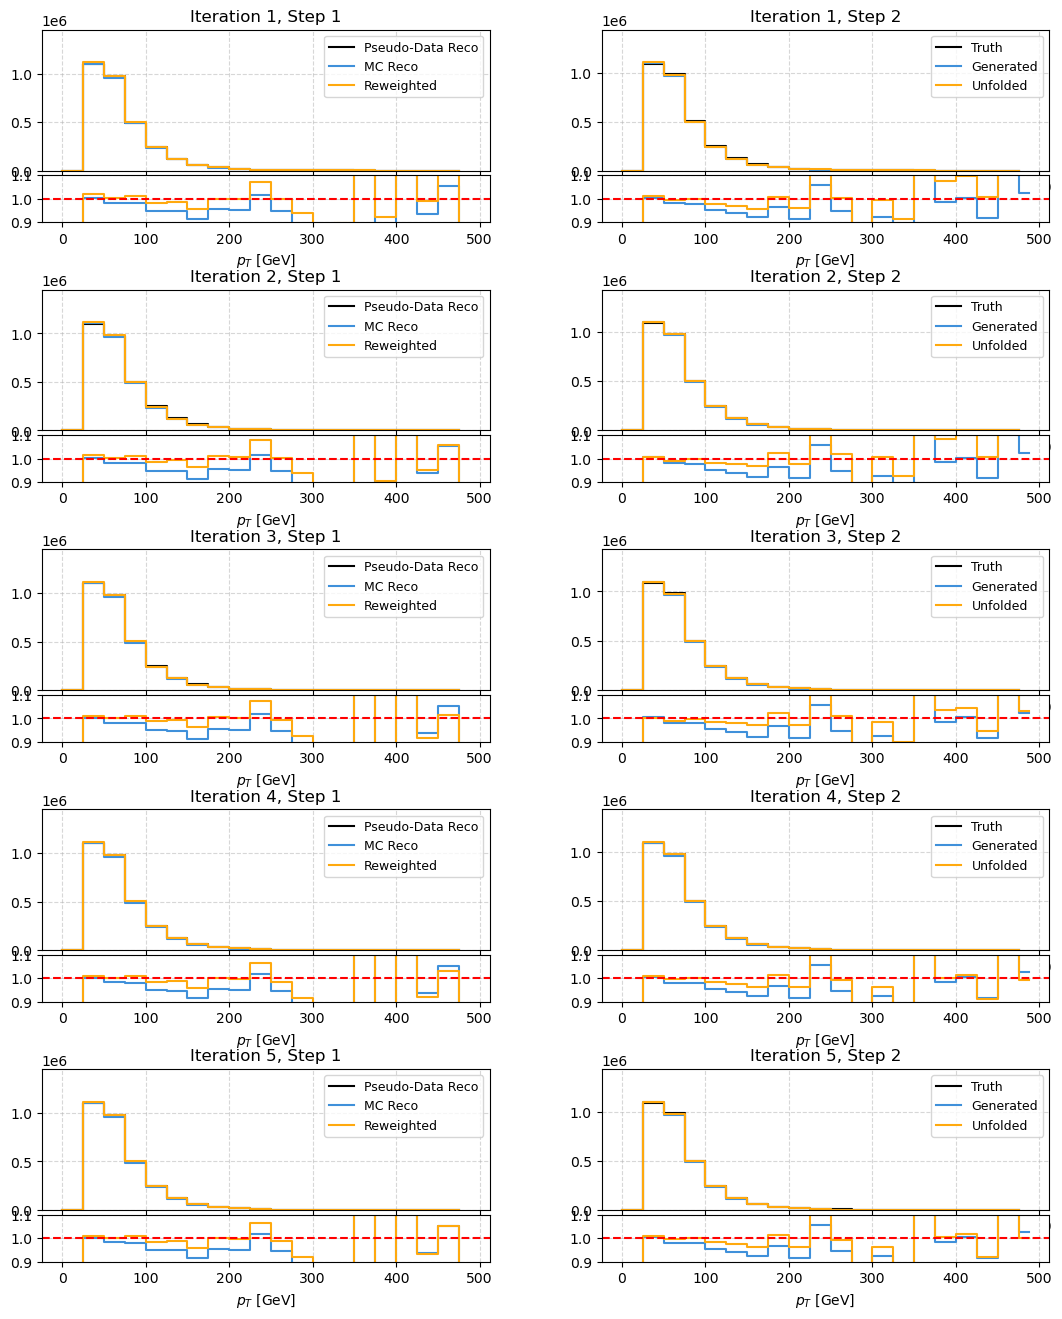

In [64]:
plot_all_iterations_updated(n_iterations=5)
